In [54]:
# pip install matplotlib

     ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
     --- ------------------------------------ 0.7/7.6 MB 15.1 MB/s eta 0:00:01
     ------------------------------ --------- 5.7/7.6 MB 61.6 MB/s eta 0:00:01
     ---------------------------------------- 7.6/7.6 MB 60.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/163.0 kB ? eta -:--:--
     ---------------------------------------- 163.0/163.0 kB ? eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------------------------------------- 1.0/1.0 MB 66.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/55.4 kB ? eta -:--:--
     ---------------------------------------- 55.4/55.4 kB ? eta 0:00:00
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import clip
from PIL import Image
from pathlib import Path
import torchvision.datasets as dset
import pinecone
import tqdm
import matplotlib.pyplot as plt

c:\Users\Choffe\anaconda3\envs\clip\Lib\site-packages\pinecone\index.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
data_path = Path(r"Flicker8k_Dataset")
img_files = list(data_path.iterdir())
print(len(img_files))

8091


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


In [21]:
image = preprocess(Image.open(str(img_files[0]))).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

100%|███████████████████████████████████████| 338M/338M [00:26<00:00, 13.4MiB/s]


Label probs: [[0.17036009 0.31832677 0.5113131 ]]


In [18]:

pinecone.init(api_key="39d5c47b-c7a3-4272-9c57-8a252d19fbc3", environment="eu-west1-gcp")
index = pinecone.Index("clip-emb")

In [19]:
i = 0
for img_path in tqdm.tqdm(data_path.iterdir()):
    image = preprocess(Image.open(str(img_path))).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        feat_list = image_features[0].tolist()
        upsert_response = index.upsert(
            vectors=[
                (
                img_path.name,                # Vector ID 
                feat_list,  # Dense vector values
                {"test": "clip"}     # Vector metadata
                ),
            ],
            namespace="clip-flickr"
        )
    i += 1

print("Done!!")

8091it [15:38,  8.63it/s]

Done!!


Done!!


In [25]:
logits_per_image

tensor([[17.7821, 18.4073, 18.8812]])

In [5]:
feat_list = image_features[0].tolist()

update_response = index.update(
    id="test",
    values=feat_list,
    namespace="clip-flickr"
)


NameError: name 'image_features' is not defined

In [20]:
i = 0
img_path = list(data_path.iterdir())[-1]
image = preprocess(Image.open(str(img_path))).unsqueeze(0).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    feat_list = image_features[0].tolist()

In [21]:
img_path.name

'997722733_0cb5439472.jpg'

In [22]:
query_response = index.query(
    namespace="clip-flickr",
    top_k=10,
    include_values=True,
    include_metadata=True,
    vector=feat_list,
)


query_response

{'matches': [{'id': '997722733_0cb5439472.jpg',
              'metadata': {'test': 'clip'},
              'score': 1.00000012,
              'values': [0.124268942,
                         0.397856772,
                         -0.286504686,
                         0.172684416,
                         -0.148603648,
                         0.0716011152,
                         0.195953935,
                         -0.233467013,
                         -0.20946753,
                         0.280038774,
                         0.0497138314,
                         -0.172592118,
                         0.544126093,
                         -0.31708917,
                         -0.352377117,
                         0.167185843,
                         -0.161351368,
                         -0.0718314871,
                         -0.252744526,
                         -0.107610598,
                         -0.287979782,
                         -0.0111493599,
                      

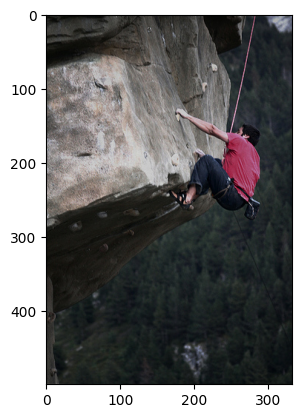

In [23]:
img = Image.open(str(img_path))
plt.imshow(img)

query_response[0]

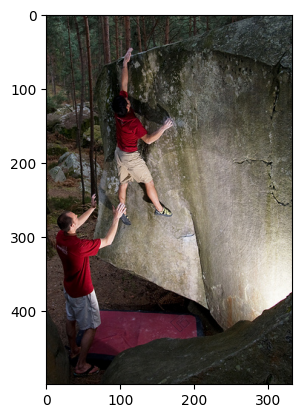

In [27]:
img_id = query_response['matches'][4]['id']
img = Image.open(str(data_path.joinpath(img_id)))
plt.imshow(img)

In [40]:
upsert_response = index.upsert(
    vectors=[
        (
         "vec1",                # Vector ID 
         feat_list,  # Dense vector values
         {"test": "clip"}     # Vector metadata
        ),
    ],
    namespace="clip-flickr"
)
upsert_response

In [41]:
upsert_response

{'upserted_count': 1}